In [1]:
import os
from dotenv import load_dotenv
import nest_asyncio

nest_asyncio.apply()  # to allow asynchronous calls in a jupyter notebook
load_dotenv()

USE_GROQ = True  # False uses OpenAI

os.getenv("GROQ_API_KEY")

# Presuming your directory structure is the default git one, this is set up to run in the main web-agent folder, so cd up one:
if "src" not in os.listdir():
    os.chdir("..")

### Imports

In [2]:
from src.custom_types import BBox, Prediction, AgentState
from src.tools import click, type_text, scroll, wait, go_back, to_google
from src.llms import ChatShowUI
from src.utils import (
    format_descriptions,
    mark_page,
    annotate,
    format_descriptions,
    parse_formatter_string,
    parse,
    generate_prompt_template,
)
from src.prompts import REFORMULATOR_PROMPT

from src.omniparser import OmniParser, OmniParserConfig

from langchain_openai import ChatOpenAI
from langchain_core.runnables import Runnable, RunnablePassthrough, RunnableLambda
from langchain_core.prompts import (
    PromptTemplate,
    HumanMessagePromptTemplate,
    ChatPromptTemplate,
    MessagesPlaceholder,
)
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import HumanMessage

from langgraph.graph import END, START, StateGraph

from typing import List, Dict, Any, Callable, Union, Literal
from langgraph.types import Command
import re

SCREEN_WIDTH=1280
SCREEN_HEIGHT=720


### Auxiliary Funcitons

In [3]:
# utility function for base64 encoding an image
import base64


def encode_image(image_str: bytes):
    # TODO(dominic): should probably add some isinstance clauses
    return base64.b64encode(image_str).decode("utf-8")


# A utility function which serves as `annotate` did in previous instantiation, but it just fetches image.
async def fetch_screenshot(state: AgentState) -> AgentState:
    screenshot = await state["page"].screenshot()
    encoded_screenshot = encode_image(screenshot)
    print("Got encoded screenshot...")

    return {**state, "img": encoded_screenshot}

# Define the Agents and the Nodes

### Define the Orchestrator Agent Node

In [4]:
orchestrator_system_prompt = """You are an AI system specialized in high level reasoning. Your goal is to generate a step by step plan for other specialized AIs to perform web actions to reach an objective supplied by users.
Your inputs are:
- objective ('str'): a high level description of the goal to achieve.
- previous_instructions ('str'): the instructions you had at the previous steps
- screenshot ('image'): a screenshot of the current state of the browser. The screenshot will be annotated with indexed bounding boxes

Your outputs are:
- Thoughts ('str'): a list of thoughts in bullet points detailing your reasoning
- Plan ('str'): a list in YAML format of the tasks to be performed to achieve the objective and the agent to perform them.

The other agents at your disposal are:
- Navigation Agent: This agent is responsible for purely navigational actions such as clicking on a button, typing input into a field, etc. It is capable of determining the coordinates of interactable elements from the screenshot.
- Action Agent: This is responsible for more complex tasks involved in web navigation such as sliders or other interactable elements which may require inspecting the HTML. 
- Extraction Agent: This agent is responsible for extracting requested information from a website which is asked for by the objective and saving that for later use. 

# General Guidelines
- Eash task should have the following format `[ENGINE]: [TASK]`
- If previous instructions or tasks failed, indicated by a [FAILED] prefix, reflect on the mistake and try to leverage other visual or textual cues to reach the objective.

# Navigation Agent Guidelines
- When specifying a task for the Navigation Agent, make sure to generate tasks which are specific and succinct. 
- Make sure to use the screenshot to specify which elements you want the Navigation Agent to interact with. 
- The Navigation Agent is capable of all simple navigation actions such as scrolling, clicking, entering text. 
- The Navigation Agent is capable of determining the exact coordinates of an element, you only need to provide the name of the element or a general area. 

# Action Agent Guidelines:
- This agent will be seldom used but is a more sophisticated approach to interact with something in a webpage. 

# Extraction Agent Guidelines:
- This agent is solely responsible for extracted information from a website relevant to the main objective. 
- This agent will create structured output of the extracted information and save it. 

Here is the objective:
Objective: {objective}
Previous Instructions:
"""

prompt = ChatPromptTemplate.from_messages(
    [
        ("user", orchestrator_system_prompt),
        MessagesPlaceholder("scratchpad", optional=True),
        (
            "user",
            [
                {
                    "type": "image_url",
                    "image_url": {"url": "data:image/png;base64,{img}"},
                }
            ],
        ),
    ]
)

In [5]:
# for message in prompt.messages:
#     message.pretty_print()

In [6]:
from langchain_groq import ChatGroq


mm_llm = ChatOpenAI(model="gpt-4o")
# llm = ChatGroq(model="llama-3.1-8b-instant")
llm = ChatGroq(model="llama-3.3-70b-versatile")

In [7]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x16cce8b00>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x16cce95b0>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [8]:
orchestrator_agent = prompt | mm_llm | StrOutputParser()

async def orchestrator_node(state: AgentState) -> Command[Literal["formatter", "__end__"]]:
    screenshot = await state["page"].screenshot()
    encoded_screenshot = encode_image(screenshot)
    prediction = await orchestrator_agent.ainvoke({**state, "img": encoded_screenshot}) # TODO: this is inelegant considering the udpate below...

    # Add logic to determine if we have the answer or need to proceed to formatter
    if "ANSWER" in prediction:
        # TODO(dominic): We probably need to add some logic here to extract answer etc. 
        return Command(
            goto="__end__"
        )

    return Command(
        update={
            "prediction": prediction,
            "img": encoded_screenshot
        },
        goto = "formatter"
    )


### Define the Formatter Node

In [9]:
reformulation_prompt_template = PromptTemplate.from_template(
    """You are a an AI which is part of a multi-agent system. Your role is to take the instructions from the main agent and reformulate it so that it is in a json formatted string. You are doing this so that other agents can easily access the information they need to perform their responsibilities. Please follow the following guidelines. 

- The main agent gives output which includes `Thoughts` and `Plan`. 
- The `Plan` is a YAML formatted list of tasks. 
- Create a JSON string from the agent's output which has the fields `thoughts` and `tasks`.
- The 'thought' should be kept as a single string.
- The 'plan' should be formatted as a list of strings consistent with json serialization.
- You do not need to provide any code or explain yourself, your task is solely to write the required JSON formatted output.
- return only the json string, you need not predicate it with something like "```json".

Agent Output:
{prediction}
"""
)
reformulation_prompt_template.pretty_print()

You are a an AI which is part of a multi-agent system. Your role is to take the instructions from the main agent and reformulate it so that it is in a json formatted string. You are doing this so that other agents can easily access the information they need to perform their responsibilities. Please follow the following guidelines. 

- The main agent gives output which includes `Thoughts` and `Plan`. 
- The `Plan` is a YAML formatted list of tasks. 
- Create a JSON string from the agent's output which has the fields `thoughts` and `tasks`.
- The 'thought' should be kept as a single string.
- The 'plan' should be formatted as a list of strings consistent with json serialization.
- You do not need to provide any code or explain yourself, your task is solely to write the required JSON formatted output.
- return only the json string, you need not predicate it with something like "```json".

Agent Output:
{prediction}



In [10]:
from src.custom_types import Plan


formatter = RunnablePassthrough.assign(
    plan=reformulation_prompt_template
    | llm
    | StrOutputParser()
    | parse_formatter_string
)    


### 

### Navigation Agent

In [11]:
from src.llms import ChatShowUI, SHOWUI_ACTIONS, SHOWUI_NAV_FORMAT, SHOWUI_NAV_SYSTEM
from src.utils import parse_llm_output

showui = ChatShowUI()

system_prompt = SHOWUI_NAV_SYSTEM.format(
                _APP="web", _ACTION_SPACE=SHOWUI_ACTIONS, _NAV_FORMAT=SHOWUI_NAV_FORMAT
            )

showui_template = ChatPromptTemplate.from_messages(
            [
                ("user", system_prompt),
                ("user", "Task: {query}"),
                (
                    "user",
                    [
                        {
                            "type": "image_url",
                            "image_url": {"url": "data:image/png;base64,{img}"},
                        }
                    ],
                ),
            ]
        )

def get_task(state: AgentState) -> str:
        print(state)
        return {"query": state["plan"]["tasks"][0], "img": state["img"]}

nav_agent = RunnablePassthrough.assign(
            next_actions=get_task
            | showui_template
            | showui
            | StrOutputParser()
            | parse_llm_output
        )

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


### Executor Node

In [35]:
from src.nav_tools import click, type_text, hover, answer, enter, scroll, select_text, copy

tools = {
            "CLICK": click,
            "INPUT": type_text,
            "SELECT": click,
            "HOVER": hover,
            "ANSWER": answer,
            "ENTER": enter,
            "SCROLL": scroll,
            "SELECT_TEXT": select_text,
            "COPY": copy,
            # These next three are not known to the agent to be options
            "WAIT": wait,
            "GO_BACK": go_back,
            "GOOGLE": to_google,
        }

async def execute_actions(state: AgentState):
        """Function which takes the actions generated by the NavAgent, routes to corresponding functions, and executes"""
        next_actions = state.get("next_actions")
        scratchpad_additions = []

        prev_url = state["page"].url
        exit_code = "SUCCESS"
        page = state["page"]
        try:
            for action in next_actions:
                value, position = action["value"], action["position"]
                # unnormalize the positio if not None
                if position:
                    position = [position[0] * SCREEN_WIDTH, position[1] * SCREEN_HEIGHT]
                observation = await tools[action["action"]](page, value, position)
                scratchpad_additions.append(observation)
                # TODO(Ben): screenshot comparator here connected to exit code: STATE_CHANGE_FAILURE
                if prev_url != state["page"].url:
                    exit_code = "URL_CHANGE"
                    break
                if action["action"].lower() == "answer":
                    exit_code = "ANSWER"
                    break
        except Exception as e:
            print(f"Exception: {str(e)}")
            # introduce logic to figure out the exit code
            exit_code = "TOTAL_FAILURE"  # TODO: not all exceptions should necesarily be treated as total_failure, scope this out
            raise

        state["nav_scratchpad"] = scratchpad_additions

        return {**state, "exit_code": exit_code}

### Evaluator Agent

In [13]:
evaluator_system_prompt = """You are a high reasoning AI which is tasked with evaluating the current state of a web navigation system. More specifically, your job is to determine, given a list of recently performed navigation tasks and a list of planned tasks, an objective, and a screenshot of the current browser, whether we are currently on track and should move onto the next task, need to modify the next task, or completely reevaluate the plan. 

Your inputs are:
    - previous_tasks (list): A list of the previous navigation tasks.
    - past_actions (list): A list of the recent previously performed actions. 
    - next_tasks (list): A list of the planned next navigation tasks.
    - objective (str): The overall objective guiding our actions.
    - screenshot (image):  A screenshot of the current state of the browser.

Outputs:
    - Thoughts (str): Your thoughts on your evaluation. 
    - Instruction (str): A string to be formatted according to the guidelines below. 
    
# Guidelines
1. If you wish to modify the next task, return the modified next task in the following format: [MODIFY] {{the modified task}}
2. If you want the next task to proceed as planned, then return using the format: [CONTINUE]
3. If you judge that we need to completely adjust our plans give a short reason why and return that thought using the format: [REPLAN] {{your reasoning}}
4. If you find that we have achieved the objective return the answer using the format: [ANSWER] {{the answer}}

previous_tasks: {previous_tasks}
past_actions: {past_actions}
next_tasks: {next_tasks}
objective: {objective}
"""

evaluator_prompt_template = ChatPromptTemplate.from_messages(
    [
        ("user", evaluator_system_prompt),
        (
            "user",
            [
                {
                    "type": "text", "text": "Screenshot: ",
                },
                {
                    "type": "image_url",
                    "image_url": {"url": "data:image/png;base64,{img}"}
                }
            ]
        )
    ]
)

# for message in evaluator_prompt_template.messages:
#     message.pretty_print()


In [14]:
from io import BytesIO
import requests
from PIL import Image, ImageDraw


def draw_point(image_input, point=None, radius=5):
    if isinstance(image_input, str):
        image = (
            Image.open(BytesIO(requests.get(image_input).content))
            if image_input.startswith("http")
            else Image.open(image_input)
        )
    elif isinstance(image_input, bytes):
        image = Image.open(BytesIO(image_input)).convert("RGB")
    else:
        image = image_input

    if point:
        x, y = point[0] * image.width, point[1] * image.height
        ImageDraw.Draw(image).ellipse(
            (x - radius, y - radius, x + radius, y + radius), fill="red"
        )
    display(image)
    return image

from src.utils import encode_image

In [15]:
evaluator_agent = evaluator_prompt_template | mm_llm | StrOutputParser()

 # Exit code options: SUCCESS, URL_CHANGE, STATE_CHANGE_FAILURE, TOTAL_FAILURE

async def evaluator_node(state: AgentState) -> Command[Literal["orchestrator", "navigator"]]:
    exit_code = state['exit_code']
    last_task = state['plan']['tasks'].pop(0)
    print(last_task)
    txt = state['scratchpad'][0].content if state['scratchpad'] else ""
    task_line = f"\n - Exit code: {exit_code}, Task: {last_task}"
    if exit_code == "TOTAL_FAILURE" or exit_code == "URL_CHANGE" or (exit_code == "SUCCESS" and not state['plan']['tasks']):
        txt += task_line
        return Command(
            update = {
                "scratchpad": [HumanMessage(content=txt)],
                "nav_scratchpad": []
            },
            goto = "orchestrator"
        )
    elif exit_code == "STATE_CHANGE_FAILURE":
        raise NotImplementedError("Currently STATE_CHANGE_FAILURE shouldn't occur, we need to figure out what to do.")
    elif exit_code == "SUCCESS" and state['plan']['tasks']:
        updated_screenshot = await state['page'].screenshot()
        updated_encoded_image = encode_image(updated_screenshot)
        last_action = None
        if state['next_actions']:
            # grab the last action
            idx = len(state['nav_scratchpad'])
            last_action = state['next_actions'][idx-1]
        
        if last_action:
            updated_screenshot = draw_point(updated_screenshot, last_action['position'])
        evaluation = await evaluator_agent.ainvoke({
            "previous_tasks": txt,
            "past_actions": state['nav_scratchpad'],
            "next_tasks": "\n - ".join(state['plan']['tasks']),
            "objective": state['objective'],
            "img": encode_image(updated_screenshot)
        })
        print(evaluation)
        # parse evaluation
        thoughts, args = re.split(r"\[(?:CONTINUE|REPLAN|MODIFY|ANSWER)\]", evaluation, maxsplit=1)
        case = re.search(r"\[(?:CONTINUE|REPLAN|MODIFY|ANSWER)\]", evaluation)
        if case is not None:
            case = case.group(0)
        else:
            raise Exception

        if case == "[MODIFY]":
            new_plan = state['plan']
            new_plan['tasks'][0] = args # the evaluator has determined the next task needs changing
            return Command(
                update={
                    "plan": new_plan, 
                    "img": updated_encoded_image
                },
                goto="navigator"
            )
        elif case == "[CONTINUE]":
            return Command(
                update={
                    "img": updated_encoded_image
                },
                goto="navigator"
            )
        elif case == "[REPLAN]":
            txt += f"\n - Attempted task: {last_task}"
            txt += f"\n - Need to replan because: {args}"
            return Command(
                update={
                    "scratchpad": [HumanMessage(content=txt)],
                    "nav_scratchpad": [], 
                    "img": updated_encoded_image
                },
                goto = "orchestrator"
            )
        elif case == "[ANSWER]":
            txt += task_line
            txt += f"\n - [ANSWER]: {args}"
            return Command(
                update={
                    "scratchpad": [HumanMessage(content=txt)], 
                    "img": updated_encoded_image, 
                    "nav_scratchpad": []
                },
                goto="orchestrator"
            )
        else: NotImplementedError("Evaluator has returned unexpected flag...")
    

## Creating the Full Agent

In [16]:
graph_builder = StateGraph(AgentState)

In [17]:
# Add in the nodes
graph_builder.add_node("orchestrator", orchestrator_node)
graph_builder.add_edge(START, "orchestrator")


graph_builder.add_node("formatter", formatter)
# graph_builder.add_edge("orchestrator", "formatter")

# add in nav agent
graph_builder.add_node("navigator", nav_agent)
graph_builder.add_edge("formatter", "navigator")

# add in executor
graph_builder.add_node("executor", execute_actions)
graph_builder.add_edge("navigator", "executor")

graph_builder.add_node("evaluator", evaluator_node)
graph_builder.add_edge("executor", "evaluator")

graph = graph_builder.compile()

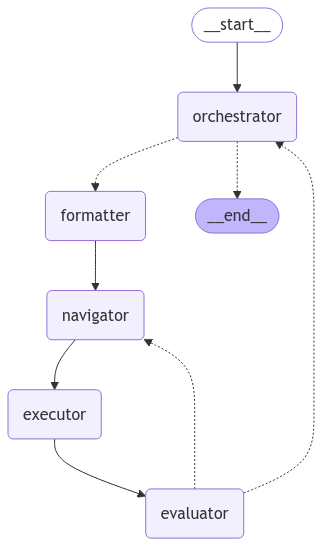

In [18]:
from IPython.display import Image as displayifier
from IPython.display import display

try:
    display(displayifier(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Test the graph

In [19]:
from playwright.async_api import async_playwright

SCREEN_WIDTH=1280
SCREEN_HEIGHT=720

# open a browser
browser = await async_playwright().start()
# We will set headless=False so we can watch the agent navigate the web.
browser = await browser.chromium.launch(headless=False, args=None)
page = await browser.new_page()
await page.set_viewport_size({"width": SCREEN_WIDTH, "height": SCREEN_HEIGHT})
_ = await page.goto("https://www.google.com/")



In [20]:
initial_state = {
    "page": page,
    "objective": "What is the weather in San Francisco?",
    "scratchpad": [],
    "nav_scratchpad": []
}

In [21]:
# event = await graph.ainvoke(input=initial_state)

In [22]:
orchestrator_output = await orchestrator_node(initial_state)
orchestrator_output

Command(update={'prediction': '**Thoughts:**\n\n- The objective is to find out the weather in San Francisco.\n- The current screenshot shows the Google search homepage.\n- We need to enter "weather in San Francisco" into the search bar to retrieve the required information.\n\n**Plan:**\n\n```yaml\n- [Navigation Agent]: Enter "weather in San Francisco" into the search bar.\n- [Navigation Agent]: Click on the "Google Search" button.\n- [Extraction Agent]: Extract the weather information displayed for San Francisco from the search results.\n```', 'img': 'iVBORw0KGgoAAAANSUhEUgAABQAAAALQCAIAAABAH0oBAAAAAXNSR0IArs4c6QAAIABJREFUeJzs3Xd4FOXaBvDnnZntm14ICYQQOoEEJAiidCkqihQpKioiIsIRO4iNDz2IB1QsiIXeRKQoKKAg0nsLNbQAISEhvW2f8v0xsC5JgEA2BMj9u7hy7c5OeTdkk733eQtTFIUAAAAAAAAA7nZcZTcAAAAAAAAA4FZAAAYAAAAAAIAqAQEYAAAAAAAAqgQEYAAAAAAAAKgSEIABAAAAAACgSkAABgAAAAAAgCoBARgAAAAAAACqBARgAAAAAAAAqBIQgAEAAAAAAKBKECq7AQAAAAAAAOAF2xItm48W7U+ynUxzpOW6imySrFR2m4iIiGNkNvDVAzT1quuaRxvaNja3aWiqlJYwRbk9viUAAAAAAABw45LSHb

In [23]:
orchestrator_output_state = {**initial_state, **orchestrator_output.update}
orchestrator_output_state

{'page': <Page url='https://www.google.com/'>,
 'objective': 'What is the weather in San Francisco?',
 'scratchpad': [],
 'nav_scratchpad': [],
 'prediction': '**Thoughts:**\n\n- The objective is to find out the weather in San Francisco.\n- The current screenshot shows the Google search homepage.\n- We need to enter "weather in San Francisco" into the search bar to retrieve the required information.\n\n**Plan:**\n\n```yaml\n- [Navigation Agent]: Enter "weather in San Francisco" into the search bar.\n- [Navigation Agent]: Click on the "Google Search" button.\n- [Extraction Agent]: Extract the weather information displayed for San Francisco from the search results.\n```',
 'img': 'iVBORw0KGgoAAAANSUhEUgAABQAAAALQCAIAAABAH0oBAAAAAXNSR0IArs4c6QAAIABJREFUeJzs3Xd4FOXaBvDnnZntm14ICYQQOoEEJAiidCkqihQpKioiIsIRO4iNDz2IB1QsiIXeRKQoKKAg0nsLNbQAISEhvW2f8v0xsC5JgEA2BMj9u7hy7c5OeTdkk733eQtTFIUAAAAAAAAA7nZcZTcAAAAAAAAA4FZAAAYAAAAAAIAqAQEYAAAAAAAAqgQEYAAAAAAAAKgSEIABAAAAAACgSkAABgAAAAAAgCoBARgAAAAAAACq

In [24]:
formatter_output = await formatter.ainvoke(orchestrator_output_state)
formatter_output

{'page': <Page url='https://www.google.com/'>,
 'objective': 'What is the weather in San Francisco?',
 'scratchpad': [],
 'nav_scratchpad': [],
 'prediction': '**Thoughts:**\n\n- The objective is to find out the weather in San Francisco.\n- The current screenshot shows the Google search homepage.\n- We need to enter "weather in San Francisco" into the search bar to retrieve the required information.\n\n**Plan:**\n\n```yaml\n- [Navigation Agent]: Enter "weather in San Francisco" into the search bar.\n- [Navigation Agent]: Click on the "Google Search" button.\n- [Extraction Agent]: Extract the weather information displayed for San Francisco from the search results.\n```',
 'img': 'iVBORw0KGgoAAAANSUhEUgAABQAAAALQCAIAAABAH0oBAAAAAXNSR0IArs4c6QAAIABJREFUeJzs3Xd4FOXaBvDnnZntm14ICYQQOoEEJAiidCkqihQpKioiIsIRO4iNDz2IB1QsiIXeRKQoKKAg0nsLNbQAISEhvW2f8v0xsC5JgEA2BMj9u7hy7c5OeTdkk733eQtTFIUAAAAAAAAA7nZcZTcAAAAAAAAA4FZAAAYAAAAAAIAqAQEYAAAAAAAAqgQEYAAAAAAAAKgSEIABAAAAAACgSkAABgAAAAAAgCoBARgAAAAAAACq

In [25]:
nav_output = await nav_agent.ainvoke(formatter_output)
nav_output

{'page': <Page url='https://www.google.com/'>, 'objective': 'What is the weather in San Francisco?', 'scratchpad': [], 'nav_scratchpad': [], 'prediction': '**Thoughts:**\n\n- The objective is to find out the weather in San Francisco.\n- The current screenshot shows the Google search homepage.\n- We need to enter "weather in San Francisco" into the search bar to retrieve the required information.\n\n**Plan:**\n\n```yaml\n- [Navigation Agent]: Enter "weather in San Francisco" into the search bar.\n- [Navigation Agent]: Click on the "Google Search" button.\n- [Extraction Agent]: Extract the weather information displayed for San Francisco from the search results.\n```', 'img': 'iVBORw0KGgoAAAANSUhEUgAABQAAAALQCAIAAABAH0oBAAAAAXNSR0IArs4c6QAAIABJREFUeJzs3Xd4FOXaBvDnnZntm14ICYQQOoEEJAiidCkqihQpKioiIsIRO4iNDz2IB1QsiIXeRKQoKKAg0nsLNbQAISEhvW2f8v0xsC5JgEA2BMj9u7hy7c5OeTdkk733eQtTFIUAAAAAAAAA7nZcZTcAAAAAAAAA4FZAAAYAAAAAAIAqAQEYAAAAAAAAqgQEYAAAAAAAAKgSEIABAAAAAACgSkAABgAAAAAAgCoBARgAAAAAAACqBARgA

{'page': <Page url='https://www.google.com/'>,
 'objective': 'What is the weather in San Francisco?',
 'scratchpad': [],
 'nav_scratchpad': [],
 'prediction': '**Thoughts:**\n\n- The objective is to find out the weather in San Francisco.\n- The current screenshot shows the Google search homepage.\n- We need to enter "weather in San Francisco" into the search bar to retrieve the required information.\n\n**Plan:**\n\n```yaml\n- [Navigation Agent]: Enter "weather in San Francisco" into the search bar.\n- [Navigation Agent]: Click on the "Google Search" button.\n- [Extraction Agent]: Extract the weather information displayed for San Francisco from the search results.\n```',
 'img': 'iVBORw0KGgoAAAANSUhEUgAABQAAAALQCAIAAABAH0oBAAAAAXNSR0IArs4c6QAAIABJREFUeJzs3Xd4FOXaBvDnnZntm14ICYQQOoEEJAiidCkqihQpKioiIsIRO4iNDz2IB1QsiIXeRKQoKKAg0nsLNbQAISEhvW2f8v0xsC5JgEA2BMj9u7hy7c5OeTdkk733eQtTFIUAAAAAAAAA7nZcZTcAAAAAAAAA4FZAAAYAAAAAAIAqAQEYAAAAAAAAqgQEYAAAAAAAAKgSEIABAAAAAACgSkAABgAAAAAAgCoBARgAAAAAAACq

In [26]:
execute_actions_output = await execute_actions(nav_output)
execute_actions_output

{'page': <Page url='https://www.google.com/'>,
 'objective': 'What is the weather in San Francisco?',
 'scratchpad': [],
 'nav_scratchpad': ['Clicked at position [627.2, 259.2]',
  'Typed weather in San Francisco into [627.2, 259.2]'],
 'prediction': '**Thoughts:**\n\n- The objective is to find out the weather in San Francisco.\n- The current screenshot shows the Google search homepage.\n- We need to enter "weather in San Francisco" into the search bar to retrieve the required information.\n\n**Plan:**\n\n```yaml\n- [Navigation Agent]: Enter "weather in San Francisco" into the search bar.\n- [Navigation Agent]: Click on the "Google Search" button.\n- [Extraction Agent]: Extract the weather information displayed for San Francisco from the search results.\n```',
 'img': 'iVBORw0KGgoAAAANSUhEUgAABQAAAALQCAIAAABAH0oBAAAAAXNSR0IArs4c6QAAIABJREFUeJzs3Xd4FOXaBvDnnZntm14ICYQQOoEEJAiidCkqihQpKioiIsIRO4iNDz2IB1QsiIXeRKQoKKAg0nsLNbQAISEhvW2f8v0xsC5JgEA2BMj9u7hy7c5OeTdkk733eQtTFIUAAAAAAAAA7nZcZTcA

[Navigation Agent]: Enter "weather in San Francisco" into the search bar.


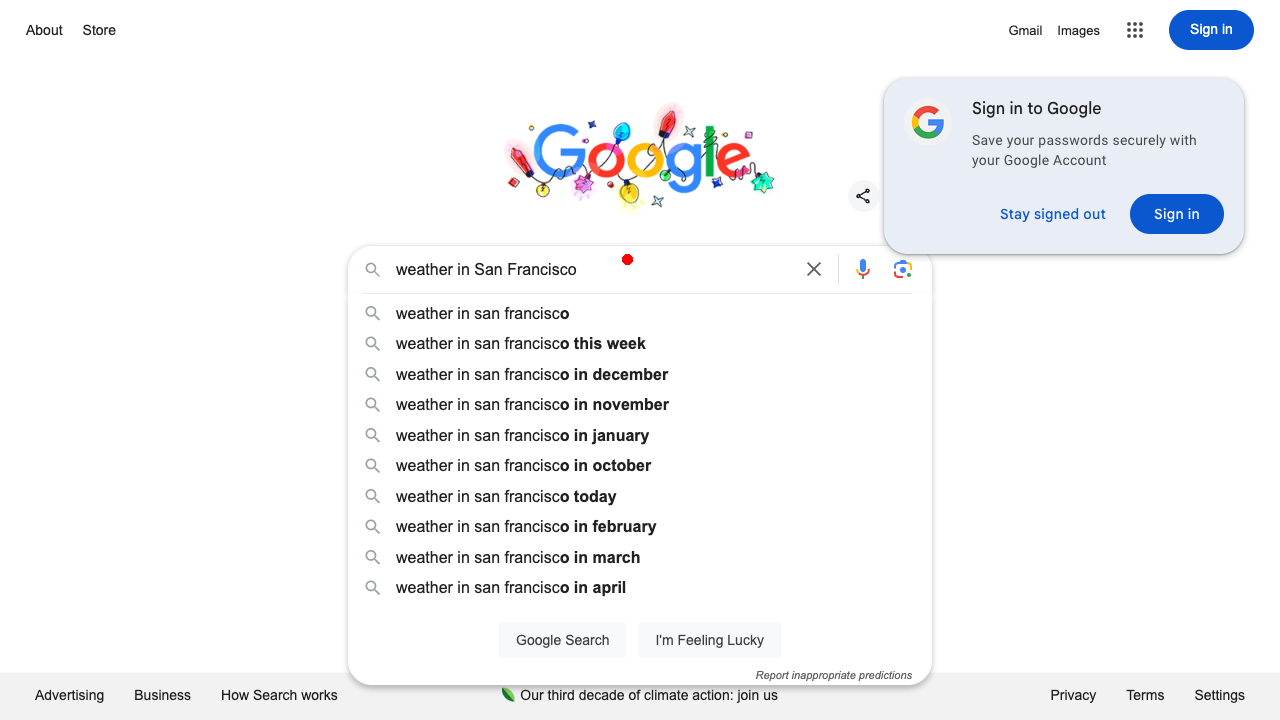

**Thoughts:** Based on the screenshot, the search query "weather in San Francisco" has been entered but not yet executed. The next step in the plan is to click on the "Google Search" button, which aligns with progressing towards the objective of finding the weather in San Francisco.

**Instruction:** [CONTINUE]


Command(update={'img': 'iVBORw0KGgoAAAANSUhEUgAABQAAAALQCAIAAABAH0oBAAAAAXNSR0IArs4c6QAAIABJREFUeJzs3Xd4FFXbBvDnzMz23fSEQCCEXiIJVRABKVJUkBdBERUVERHhtSuKjQ99sWDBioXeRKQoKmJDBQEB6S20EEJCQnrbPjPn+2NgWZKAgWwSIPfv4so1mZ1yNqTsvc8pjHNOAAAAAAAAAFc7oaYbAAAAAAAAAFAdEIABAAAAAACgVkAABgAAAAAAgFoBARgAAAAAAABqBQRgAAAAAAAAqBUQgAEAAAAAAKBWQAAGAAAAAACAWgEBGAAAAAAAAGoFBGAAAAAAAACoFaSabgAAAAAAAAAEwMYk+/r9JTuSnYcz3Bn53hKnovKabhMREQmMrCaxbqiuWV1Du8am7q2tXVtaaqQljPPL40sCAAAAAAAAFy850z1nbd7Sv/LT87w13ZaKignT3dEtdFTvsMbRhuq8LwIwAAAAAADAFSmrUH59WeYXv+TWdEMu3Zi+4c8Pi44Krqa+yQjAAAAAAAAAV555v+c9v+BkkUOp6YZUVpBZfH1kvft6hVXDvRCAAQAAAAAArjBPzEq7ogu/ZY3pG/7e6PpVfRcEYAAAAAAAgCvJnW+nfP9PYU23IvAGdgxe8nRcld4CyyABAAAAAABcMa7W9EtE3/9TeOfbKVV6CwRgAAAAAACAK8MTs9Ku1vSr+f6fwidmpVXd9RGAAQAAAAAArgDzfs+7ysb9luuLX3Ln/Z5XRRfHGGAAAAAAAIDLXVah3PaJpKtgzueKCDKLO99rWRVrI6ECDAAAAAAAcLl7fVlmLUm/RFTkUF5fllkVV0YABgAAAAAAuKwlZ7prQ+dnf1/8kpuc6Q74ZQNfUwYAAAAAALia7Nq9e8HCBUQ08p6RiQkJFdwTQHPWVtWY2MvZnLV5r95VN7DXRAUYAAAAAADgQhYsXLBr925fxK3gngBa+ld+

In [27]:
evaluator_output = await evaluator_node(execute_actions_output)
evaluator_output

In [28]:
evaluator_output

Command(update={'img': 'iVBORw0KGgoAAAANSUhEUgAABQAAAALQCAIAAABAH0oBAAAAAXNSR0IArs4c6QAAIABJREFUeJzs3Xd4FFXbBvDnzMz23fSEQCCEXiIJVRABKVJUkBdBERUVERHhtSuKjQ99sWDBioXeRKQoKmJDBQEB6S20EEJCQnrbPjPn+2NgWZKAgWwSIPfv4so1mZ1yNqTsvc8pjHNOAAAAAAAAAFc7oaYbAAAAAAAAAFAdEIABAAAAAACgVkAABgAAAAAAgFoBARgAAAAAAABqBQRgAAAAAAAAqBUQgAEAAAAAAKBWQAAGAAAAAACAWgEBGAAAAAAAAGoFBGAAAAAAAACoFaSabgAAAAAAAAAEwMYk+/r9JTuSnYcz3Bn53hKnovKabhMREQmMrCaxbqiuWV1Du8am7q2tXVtaaqQljPPL40sCAAAAAAAAFy850z1nbd7Sv/LT87w13ZaKignT3dEtdFTvsMbRhuq8LwIwAAAAAADAFSmrUH59WeYXv+TWdEMu3Zi+4c8Pi44Krqa+yQjAAAAAAAAAV555v+c9v+BkkUOp6YZUVpBZfH1kvft6hVXDvRCAAQAAAAAArjBPzEq7ogu/ZY3pG/7e6PpVfRcEYAAAAAAAgCvJnW+nfP9PYU23IvAGdgxe8nRcld4CyyABAAAAAABcMa7W9EtE3/9TeOfbKVV6CwRgAAAAAACAK8MTs9Ku1vSr+f6fwidmpVXd9RGAAQAAAAAArgDzfs+7ysb9luuLX3Ln/Z5XRRfHGGAAAAAAAIDLXVah3PaJpKtgzueKCDKLO99rWRVrI6ECDAAAAAAAcLl7fVlmLUm/RFTkUF5fllkVV0YABgAAAAAAuKwlZ7prQ+dnf1/8kpuc6Q74ZQNfUwYAAAAAALia7Nq9e8HCBUQ08p6RiQkJFdwTQHPWVtWY2MvZnLV5r95VN7DXRAUYAAAAAADgQhYsXLBr925fxK3gngBa+ld+

In [29]:
# back to navigator
nav_output_v2 = await nav_agent.ainvoke(execute_actions_output)
nav_output_v2

{'page': <Page url='https://www.google.com/'>, 'objective': 'What is the weather in San Francisco?', 'scratchpad': [], 'nav_scratchpad': ['Clicked at position [627.2, 259.2]', 'Typed weather in San Francisco into [627.2, 259.2]'], 'prediction': '**Thoughts:**\n\n- The objective is to find out the weather in San Francisco.\n- The current screenshot shows the Google search homepage.\n- We need to enter "weather in San Francisco" into the search bar to retrieve the required information.\n\n**Plan:**\n\n```yaml\n- [Navigation Agent]: Enter "weather in San Francisco" into the search bar.\n- [Navigation Agent]: Click on the "Google Search" button.\n- [Extraction Agent]: Extract the weather information displayed for San Francisco from the search results.\n```', 'img': 'iVBORw0KGgoAAAANSUhEUgAABQAAAALQCAIAAABAH0oBAAAAAXNSR0IArs4c6QAAIABJREFUeJzs3Xd4FOXaBvDnnZntm14ICYQQOoEEJAiidCkqihQpKioiIsIRO4iNDz2IB1QsiIXeRKQoKKAg0nsLNbQAISEhvW2f8v0xsC5JgEA2BMj9u7hy7c5OeTdkk733eQtTFIUAAAAAAAAA7nZcZTcAAAAAAAA

{'page': <Page url='https://www.google.com/'>,
 'objective': 'What is the weather in San Francisco?',
 'scratchpad': [],
 'nav_scratchpad': ['Clicked at position [627.2, 259.2]',
  'Typed weather in San Francisco into [627.2, 259.2]'],
 'prediction': '**Thoughts:**\n\n- The objective is to find out the weather in San Francisco.\n- The current screenshot shows the Google search homepage.\n- We need to enter "weather in San Francisco" into the search bar to retrieve the required information.\n\n**Plan:**\n\n```yaml\n- [Navigation Agent]: Enter "weather in San Francisco" into the search bar.\n- [Navigation Agent]: Click on the "Google Search" button.\n- [Extraction Agent]: Extract the weather information displayed for San Francisco from the search results.\n```',
 'img': 'iVBORw0KGgoAAAANSUhEUgAABQAAAALQCAIAAABAH0oBAAAAAXNSR0IArs4c6QAAIABJREFUeJzs3Xd4FOXaBvDnnZntm14ICYQQOoEEJAiidCkqihQpKioiIsIRO4iNDz2IB1QsiIXeRKQoKKAg0nsLNbQAISEhvW2f8v0xsC5JgEA2BMj9u7hy7c5OeTdkk733eQtTFIUAAAAAAAAA7nZcZTcA

In [30]:
execute_actions_output_v2 = await execute_actions(nav_output_v2)
execute_actions_output_v2

{'page': <Page url='https://www.google.com/'>,
 'objective': 'What is the weather in San Francisco?',
 'scratchpad': [],
 'nav_scratchpad': ['Clicked at position [550.4, 338.4]'],
 'prediction': '**Thoughts:**\n\n- The objective is to find out the weather in San Francisco.\n- The current screenshot shows the Google search homepage.\n- We need to enter "weather in San Francisco" into the search bar to retrieve the required information.\n\n**Plan:**\n\n```yaml\n- [Navigation Agent]: Enter "weather in San Francisco" into the search bar.\n- [Navigation Agent]: Click on the "Google Search" button.\n- [Extraction Agent]: Extract the weather information displayed for San Francisco from the search results.\n```',
 'img': 'iVBORw0KGgoAAAANSUhEUgAABQAAAALQCAIAAABAH0oBAAAAAXNSR0IArs4c6QAAIABJREFUeJzs3Xd4FOXaBvDnnZntm14ICYQQOoEEJAiidCkqihQpKioiIsIRO4iNDz2IB1QsiIXeRKQoKKAg0nsLNbQAISEhvW2f8v0xsC5JgEA2BMj9u7hy7c5OeTdkk733eQtTFIUAAAAAAAAA7nZcZTcAAAAAAAAA4FZAAAYAAAAAAIAqAQEYAAAAAAAAqgQEYAAAAAAAAKgSEIAB

[Navigation Agent]: Click on the "Google Search" button.


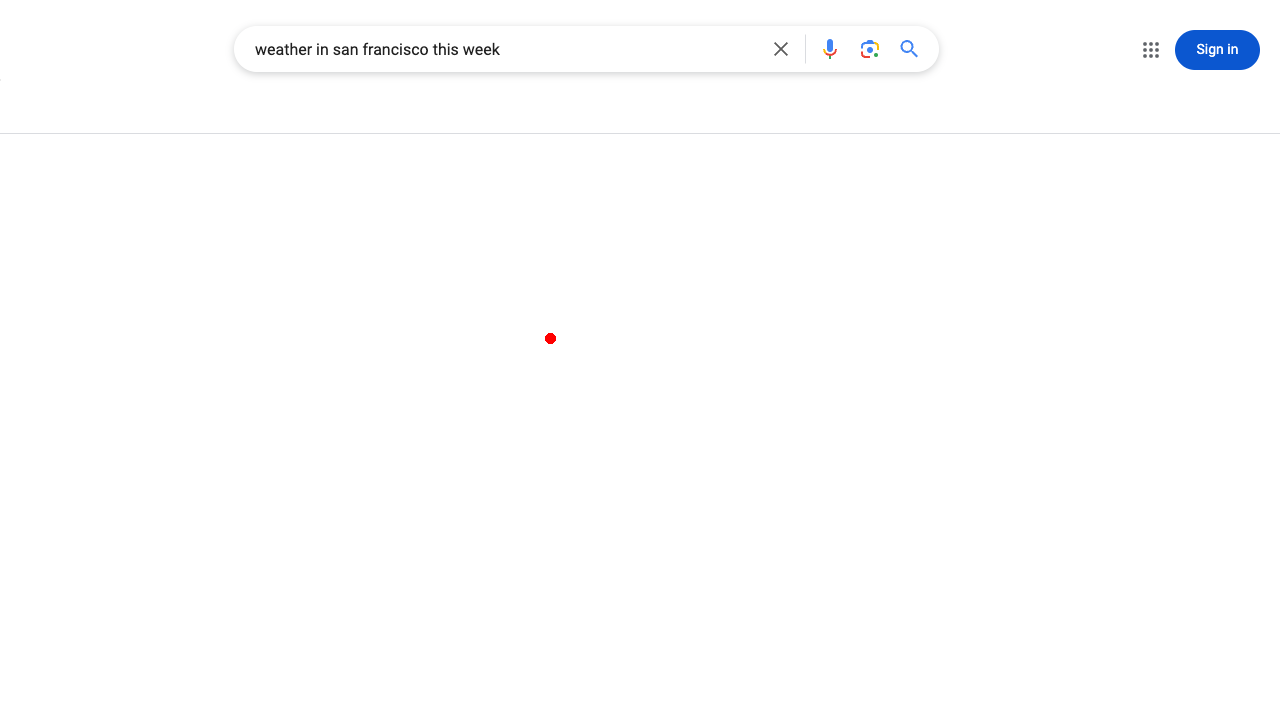

**Thoughts:** The screenshot shows a Google search for "weather in San Francisco this week," but the results are not displayed, possibly due to slow loading or an error. Given that the task is to extract weather information, we need to ensure the results are fully loaded before extracting data.

**Instruction:** [REPLAN] The search results have not loaded correctly. Refresh the page or check the internet connection to display the weather information before proceeding with extraction.


Command(update={'scratchpad': [HumanMessage(content='\n - Attempted task: [Navigation Agent]: Click on the "Google Search" button.\n - Need to replan because:  The search results have not loaded correctly. Refresh the page or check the internet connection to display the weather information before proceeding with extraction.', additional_kwargs={}, response_metadata={})], 'nav_scratchpad': [], 'img': 'iVBORw0KGgoAAAANSUhEUgAABQAAAALQCAIAAABAH0oBAAAAAXNSR0IArs4c6QAAIABJREFUeJzs3Xl8VOWh+OEzM1kIQQSCsikVFKWKcqlL1WorKoJrtdaqteJ17bXt9aq13mKrdatYqVZRiwVxgVJB6MWC1gV33OpSC2qJxR+4UVEIECSBLDPz++OQYQiLaAIxvM/DB0wmkzNn4sDMd973vCeRzWYjAAAA2NolW3oHAAAAYEsQwAAAAARBAAMAABAEAQwAAEAQBDAAAABBEMAAAAAEQQADAAAQBAEMAABAEAQwAAAAQRDAAAAABEEAAwAAEAQBDAAAQBAEMAAAAEEQwAAAAARBAAMAABAEAQwAAEAQBDAAAABBEMAAAAAEoaCldwC2tGw229K7AAA0j0Qi0dK7ALQmCTFACDzOAWCrJ4aBzySA2Zo1enhns1EUecADwFamcfkqYWBDBDBbp/wHdn73rn25Bz8AtEr5iZv38VrlK4OBdQlgtja5h3Sue+NL8i5fTwwDAK1ILm4bfdDw6Zr4lcFAPgHM1mMj6Ztd89Gaixv9BgC+9BJRIlq7bROJxJo/ZDCwcQKYrUSj

In [31]:
evaluator_output_v2 = await evaluator_node(execute_actions_output_v2)
evaluator_output_v2

In [32]:
updated_state = {**execute_actions_output_v2, **evaluator_output_v2.update}
updated_state

{'page': <Page url='https://www.google.com/search?q=weather+in+san+francisco+this+week&sca_esv=32e55b09f5ce6c02&source=hp&ei=LtFhZ4WRFLiV0PEPkK-qkA0&iflsig=AL9hbdgAAAAAZ2HfPmeGQX49dhht5qGhJU1sKNaXPNv1&oq=weather+in+San+Francisco&gs_lp=Egdnd3Mtd2l6Ihh3ZWF0aGVyIGluIFNhbiBGcmFuY2lzY28qAggBMggQABiABBixAzIFEAAYgAQyBRAAGIAEMgUQABiABDIFEAAYgAQyBRAAGIAEMgUQABiABDIFEAAYgAQyBRAAGIAEMgUQABiABEjbnAFQZli8AXACeACQAQGYATqgAcoBqgEBNLgBAcgBAPgBAZgCBaACmQGoAgrCAgoQABgDGOoCGI8BwgIKEC4YAxjqAhiPAZgDA_EF_Uvo47cgRZ6SBwE1oAe8GA&sclient=gws-wiz'>,
 'objective': 'What is the weather in San Francisco?',
 'scratchpad': [HumanMessage(content='\n - Attempted task: [Navigation Agent]: Click on the "Google Search" button.\n - Need to replan because:  The search results have not loaded correctly. Refresh the page or check the internet connection to display the weather information before proceeding with extraction.', additional_kwargs={}, response_metadata={})],
 'nav_scratchpad': [],
 'prediction': '**Thoughts:**\n\n-

In [33]:
nav_output_v3 = await nav_agent.ainvoke(updated_state)
nav_output_v3

{'page': <Page url='https://www.google.com/search?q=weather+in+san+francisco+this+week&sca_esv=32e55b09f5ce6c02&source=hp&ei=LtFhZ4WRFLiV0PEPkK-qkA0&iflsig=AL9hbdgAAAAAZ2HfPmeGQX49dhht5qGhJU1sKNaXPNv1&oq=weather+in+San+Francisco&gs_lp=Egdnd3Mtd2l6Ihh3ZWF0aGVyIGluIFNhbiBGcmFuY2lzY28qAggBMggQABiABBixAzIFEAAYgAQyBRAAGIAEMgUQABiABDIFEAAYgAQyBRAAGIAEMgUQABiABDIFEAAYgAQyBRAAGIAEMgUQABiABEjbnAFQZli8AXACeACQAQGYATqgAcoBqgEBNLgBAcgBAPgBAZgCBaACmQGoAgrCAgoQABgDGOoCGI8BwgIKEC4YAxjqAhiPAZgDA_EF_Uvo47cgRZ6SBwE1oAe8GA&sclient=gws-wiz'>, 'objective': 'What is the weather in San Francisco?', 'scratchpad': [HumanMessage(content='\n - Attempted task: [Navigation Agent]: Click on the "Google Search" button.\n - Need to replan because:  The search results have not loaded correctly. Refresh the page or check the internet connection to display the weather information before proceeding with extraction.', additional_kwargs={}, response_metadata={})], 'nav_scratchpad': [], 'prediction': '**Thoughts:**\n\n- The

{'page': <Page url='https://www.google.com/search?q=weather+in+san+francisco+this+week&sca_esv=32e55b09f5ce6c02&source=hp&ei=LtFhZ4WRFLiV0PEPkK-qkA0&iflsig=AL9hbdgAAAAAZ2HfPmeGQX49dhht5qGhJU1sKNaXPNv1&oq=weather+in+San+Francisco&gs_lp=Egdnd3Mtd2l6Ihh3ZWF0aGVyIGluIFNhbiBGcmFuY2lzY28qAggBMggQABiABBixAzIFEAAYgAQyBRAAGIAEMgUQABiABDIFEAAYgAQyBRAAGIAEMgUQABiABDIFEAAYgAQyBRAAGIAEMgUQABiABEjbnAFQZli8AXACeACQAQGYATqgAcoBqgEBNLgBAcgBAPgBAZgCBaACmQGoAgrCAgoQABgDGOoCGI8BwgIKEC4YAxjqAhiPAZgDA_EF_Uvo47cgRZ6SBwE1oAe8GA&sclient=gws-wiz'>,
 'objective': 'What is the weather in San Francisco?',
 'scratchpad': [HumanMessage(content='\n - Attempted task: [Navigation Agent]: Click on the "Google Search" button.\n - Need to replan because:  The search results have not loaded correctly. Refresh the page or check the internet connection to display the weather information before proceeding with extraction.', additional_kwargs={}, response_metadata={})],
 'nav_scratchpad': [],
 'prediction': '**Thoughts:**\n\n-

In [36]:
execute_actions_output_v3 = await execute_actions(nav_output_v3)
execute_actions_output_v3

{'page': <Page url='https://www.google.com/search?q=weather+in+san+francisco+this+week&sca_esv=32e55b09f5ce6c02&source=hp&ei=LtFhZ4WRFLiV0PEPkK-qkA0&iflsig=AL9hbdgAAAAAZ2HfPmeGQX49dhht5qGhJU1sKNaXPNv1&oq=weather+in+San+Francisco&gs_lp=Egdnd3Mtd2l6Ihh3ZWF0aGVyIGluIFNhbiBGcmFuY2lzY28qAggBMggQABiABBixAzIFEAAYgAQyBRAAGIAEMgUQABiABDIFEAAYgAQyBRAAGIAEMgUQABiABDIFEAAYgAQyBRAAGIAEMgUQABiABEjbnAFQZli8AXACeACQAQGYATqgAcoBqgEBNLgBAcgBAPgBAZgCBaACmQGoAgrCAgoQABgDGOoCGI8BwgIKEC4YAxjqAhiPAZgDA_EF_Uvo47cgRZ6SBwE1oAe8GA&sclient=gws-wiz'>,
 'objective': 'What is the weather in San Francisco?',
 'scratchpad': [HumanMessage(content='\n - Attempted task: [Navigation Agent]: Click on the "Google Search" button.\n - Need to replan because:  The search results have not loaded correctly. Refresh the page or check the internet connection to display the weather information before proceeding with extraction.', additional_kwargs={}, response_metadata={})],
 'nav_scratchpad': ['Hit enter'],
 'prediction': '**Thoug

In [37]:
evaluator_output_v3 = await evaluator_node(execute_actions_output_v3)
evaluator_output_v3

[Extraction Agent]: Extract the weather information displayed for San Francisco from the search results.


Command(update={'scratchpad': [HumanMessage(content='\n - Attempted task: [Navigation Agent]: Click on the "Google Search" button.\n - Need to replan because:  The search results have not loaded correctly. Refresh the page or check the internet connection to display the weather information before proceeding with extraction.\n - Exit code: SUCCESS, Task: [Extraction Agent]: Extract the weather information displayed for San Francisco from the search results.', additional_kwargs={}, response_metadata={})], 'nav_scratchpad': []}, goto='orchestrator')

In [38]:
updated_state_v2 = {**execute_actions_output_v3, **evaluator_output_v3.update}
updated_state_v2

{'page': <Page url='https://www.google.com/search?q=weather+in+san+francisco+this+week&sca_esv=32e55b09f5ce6c02&source=hp&ei=LtFhZ4WRFLiV0PEPkK-qkA0&iflsig=AL9hbdgAAAAAZ2HfPmeGQX49dhht5qGhJU1sKNaXPNv1&oq=weather+in+San+Francisco&gs_lp=Egdnd3Mtd2l6Ihh3ZWF0aGVyIGluIFNhbiBGcmFuY2lzY28qAggBMggQABiABBixAzIFEAAYgAQyBRAAGIAEMgUQABiABDIFEAAYgAQyBRAAGIAEMgUQABiABDIFEAAYgAQyBRAAGIAEMgUQABiABEjbnAFQZli8AXACeACQAQGYATqgAcoBqgEBNLgBAcgBAPgBAZgCBaACmQGoAgrCAgoQABgDGOoCGI8BwgIKEC4YAxjqAhiPAZgDA_EF_Uvo47cgRZ6SBwE1oAe8GA&sclient=gws-wiz'>,
 'objective': 'What is the weather in San Francisco?',
 'scratchpad': [HumanMessage(content='\n - Attempted task: [Navigation Agent]: Click on the "Google Search" button.\n - Need to replan because:  The search results have not loaded correctly. Refresh the page or check the internet connection to display the weather information before proceeding with extraction.\n - Exit code: SUCCESS, Task: [Extraction Agent]: Extract the weather information displayed for San Franc

In [39]:
orchestrator_output_v2 = await orchestrator_node(updated_state_v2)
orchestrator_output_v2

Command(update={'prediction': '**Thoughts:**\n\n- The weather information for San Francisco is visibly present on the screen.\n- The data includes current temperature, conditions, and a forecast for the week.\n- The Extraction Agent should be used to gather this information.\n\n**Plan:**\n\n```yaml\n- [Extraction Agent]: Extract the current temperature, weather conditions, and weekly forecast for San Francisco from the visible search results.\n```', 'img': 'iVBORw0KGgoAAAANSUhEUgAABQAAAALQCAIAAABAH0oBAAAAAXNSR0IArs4c6QAAIABJREFUeJzs3XdAFNfaBvD3zMw2lt6LoqAoCoq9N2zYa0w0iZpm8uUmNzfVxNyYYkz0Soot0dhLjD0a1Ngr9hIFCyhKU6SzsLB9Z873x8Cy0kRpAu/PiLvD7szZZbLLs+8phFIKCCGEEEIIIYRQQ8fUdQMQQgghhBBCCKHagAEYIYQQQgghhFCjgAEYIYQQQgghhFCjgAEYIYQQQgghhFCjgAEYIYQQQgghhFCjgAEYIYQQQgghhFCjgAEYIYQQQgghhFCjgAEYIYQQQgghhFCjgAEYIYQQQgghhFCjgAEYIYQQQgghhFCjgAEYIYQQQgghhFCjgAEYIYQQQgghhFCjgAEYIYQQQgghhFCjgAEYIYQQQgghhFCjgAEYIYQQQgghhFCjgAEYIYQQQgghhFCjgAEYIYQQQgghhFCjgAEYIYQQQgghhFCjwNV1AxCqbZTSum4CQgghhKoHIaSum4AQqk

In [40]:
orchestrator_output_v2.goto

'formatter'

In [41]:
orchestrator_output_v2.update

{'prediction': '**Thoughts:**\n\n- The weather information for San Francisco is visibly present on the screen.\n- The data includes current temperature, conditions, and a forecast for the week.\n- The Extraction Agent should be used to gather this information.\n\n**Plan:**\n\n```yaml\n- [Extraction Agent]: Extract the current temperature, weather conditions, and weekly forecast for San Francisco from the visible search results.\n```',
 'img': 'iVBORw0KGgoAAAANSUhEUgAABQAAAALQCAIAAABAH0oBAAAAAXNSR0IArs4c6QAAIABJREFUeJzs3XdAFNfaBvD3zMw2lt6LoqAoCoq9N2zYa0w0iZpm8uUmNzfVxNyYYkz0Soot0dhLjD0a1Ngr9hIFCyhKU6SzsLB9Z873x8Cy0kRpAu/PiLvD7szZZbLLs+8phFIKCCGEEEIIIYRQQ8fUdQMQQgghhBBCCKHagAEYIYQQQgghhFCjgAEYIYQQQgghhFCjgAEYIYQQQgghhFCjgAEYIYQQQgghhFCjgAEYIYQQQgghhFCjgAEYIYQQQgghhFCjgAEYIYQQQgghhFCjgAEYIYQQQgghhFCjgAEYIYQQQgghhFCjgAEYIYQQQgghhFCjgAEYIYQQQgghhFCjgAEYIYQQQgghhFCjgAEYIYQQQgghhFCjgAEYIYQQQgghhFCjgAEYIYQQQgghhFCjgAEYIYQQQgghhFCjgAEYIYQQQgghhFCjwNV1AxCqbZTSum4CQgghhKoHIaSum4AQqk8IhgHUGOB5jhBC

In [42]:
# update state
updated_state_v3 = {**updated_state_v2, **orchestrator_output_v2.update}
updated_state_v3

{'page': <Page url='https://www.google.com/search?q=weather+in+san+francisco+this+week&sca_esv=32e55b09f5ce6c02&source=hp&ei=LtFhZ4WRFLiV0PEPkK-qkA0&iflsig=AL9hbdgAAAAAZ2HfPmeGQX49dhht5qGhJU1sKNaXPNv1&oq=weather+in+San+Francisco&gs_lp=Egdnd3Mtd2l6Ihh3ZWF0aGVyIGluIFNhbiBGcmFuY2lzY28qAggBMggQABiABBixAzIFEAAYgAQyBRAAGIAEMgUQABiABDIFEAAYgAQyBRAAGIAEMgUQABiABDIFEAAYgAQyBRAAGIAEMgUQABiABEjbnAFQZli8AXACeACQAQGYATqgAcoBqgEBNLgBAcgBAPgBAZgCBaACmQGoAgrCAgoQABgDGOoCGI8BwgIKEC4YAxjqAhiPAZgDA_EF_Uvo47cgRZ6SBwE1oAe8GA&sclient=gws-wiz'>,
 'objective': 'What is the weather in San Francisco?',
 'scratchpad': [HumanMessage(content='\n - Attempted task: [Navigation Agent]: Click on the "Google Search" button.\n - Need to replan because:  The search results have not loaded correctly. Refresh the page or check the internet connection to display the weather information before proceeding with extraction.\n - Exit code: SUCCESS, Task: [Extraction Agent]: Extract the weather information displayed for San Franc

In [43]:
formatter_output_v2 = await formatter.ainvoke(updated_state_v3)
formatter_output_v2

{'page': <Page url='https://www.google.com/search?q=weather+in+san+francisco+this+week&sca_esv=32e55b09f5ce6c02&source=hp&ei=LtFhZ4WRFLiV0PEPkK-qkA0&iflsig=AL9hbdgAAAAAZ2HfPmeGQX49dhht5qGhJU1sKNaXPNv1&oq=weather+in+San+Francisco&gs_lp=Egdnd3Mtd2l6Ihh3ZWF0aGVyIGluIFNhbiBGcmFuY2lzY28qAggBMggQABiABBixAzIFEAAYgAQyBRAAGIAEMgUQABiABDIFEAAYgAQyBRAAGIAEMgUQABiABDIFEAAYgAQyBRAAGIAEMgUQABiABEjbnAFQZli8AXACeACQAQGYATqgAcoBqgEBNLgBAcgBAPgBAZgCBaACmQGoAgrCAgoQABgDGOoCGI8BwgIKEC4YAxjqAhiPAZgDA_EF_Uvo47cgRZ6SBwE1oAe8GA&sclient=gws-wiz'>,
 'objective': 'What is the weather in San Francisco?',
 'scratchpad': [HumanMessage(content='\n - Attempted task: [Navigation Agent]: Click on the "Google Search" button.\n - Need to replan because:  The search results have not loaded correctly. Refresh the page or check the internet connection to display the weather information before proceeding with extraction.\n - Exit code: SUCCESS, Task: [Extraction Agent]: Extract the weather information displayed for San Franc

In [ ]:
# from io import BytesIO
# import requests
# from PIL import Image, ImageDraw


# def draw_point(image_input, point=None, radius=5):
#     if isinstance(image_input, str):
#         image = (
#             Image.open(BytesIO(requests.get(image_input).content))
#             if image_input.startswith("http")
#             else Image.open(image_input)
#         )
#     elif isinstance(image_input, bytes):
#         image = Image.open(BytesIO(image_input)).convert("RGB")
#     else:
#         image = image_input

#     if point:
#         x, y = point[0] * image.width, point[1] * image.height
#         ImageDraw.Draw(image).ellipse(
#             (x - radius, y - radius, x + radius, y + radius), fill="red"
#         )
#     display(image)
#     return


In [ ]:
# screenshot = await execute_actions_output_v2['page'].screenshot()
# draw_point(screenshot, [0.37, 0.42])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


{'orchestrator': {'prediction': '**Thoughts:**\n\n- The goal is to find out the weather in San Francisco.\n- The current screenshot shows the Google homepage, which is suitable for conducting a search.\n- The search bar is visible and can be used to input the query.\n- We need to enter "San Francisco weather" into the search bar and execute the search.\n\n**Plan:**\n\n```yaml\n- [Navigation Agent]: Enter "San Francisco weather" into the search bar.\n- [Navigation Agent]: Click the "Google Search" button to execute the search.\n- [Extraction Agent]: Extract the weather information for San Francisco from the search results.\n```', 'img': 'iVBORw0KGgoAAAANSUhEUgAABQAAAALQCAIAAABAH0oBAAAAAXNSR0IArs4c6QAAIABJREFUeJzs3Xd4FNX6B/D3zMz23fSEQCihlwiIBEGULkVFuRRFVFRERC7eaxfExg+9losFvSoWmjQVERUVURQFpEsvhhYgpPe2bXZmzu+PCcuSBAhkQ4B8Pw9PnsnszJmzIZudd99z3sM45wQAAAAAAABwpRNquwMAAAAAAAAAFwMCYAAAAAAAAKgTEAADAAAAAABAnYAAGAAAAAAAAOoEBMAAAAAAAABQJyAABgAAAAAAgDoBATAAAAAAAADUCQiAAQAAAAAAoE5AAAwAAAAAAAB1glTbHQA

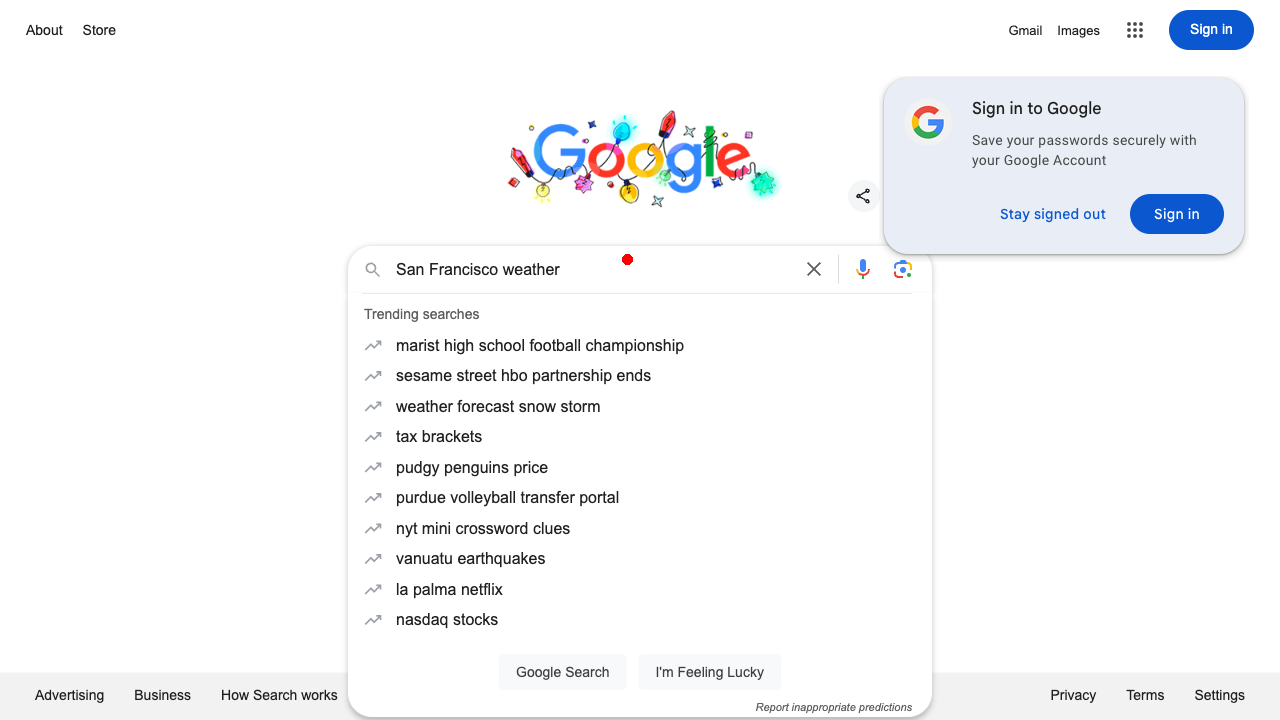

**Thoughts:**

The current state of the browser shows that the search term "San Francisco weather" has been typed into the search bar, but the search has not yet been executed. This matches our past actions and aligns with the first task in the next tasks list: clicking the "Google Search" button. 

**Instruction:**

[CONTINUE]
{'evaluator': {'img': 'iVBORw0KGgoAAAANSUhEUgAABQAAAALQCAIAAABAH0oBAAAAAXNSR0IArs4c6QAAIABJREFUeJzs3Xd4FFXbBvDnzGzfTS8EAiH0EkhAQrGAFCkqFooCKioiIsJrVxAbH/qivliwYqE3FQEVFFCQ3ksg1NCSEBIS0tv2mTnfHwNxSQIEskmA3L+Li2syO+VsyIa99zmFcc4JAAAAAAAA4GYn1HQDAAAAAAAAAKoDAjAAAAAAAADUCgjAAAAAAAAAUCsgAAMAAAAAAECtgAAMAAAAAAAAtQICMAAAAAAAANQKCMAAAAAAAABQKyAAAwAAAAAAQK2AAAwAAAAAAAC1gqamGwAAAAAAAABesC3BuvlI8b5E+4l0Z3qeu9guK7ym20RERAIji1GsG6BtVlffvrGxa2vLbS3NNdISxvn18S0BAAAAAACAq5eY4Zy9Lnfxlry0XHdNt6WiwgO1D98RMKJnYOMwfXXeFwEYAAAAAADghpRZIH2wJOOHNTk13ZBrN6p30BuDw0L9qqlvMgIwAAAAAADAjWfu+tw35p8ttMk13ZDK8jWJHwyv90SPwGq4FwIwAAAAAADADealmak3dOG3rFG9gz4bWb+q74IADAAAAAAAcCMZ+nHyH3sKaroV3tc/1u+

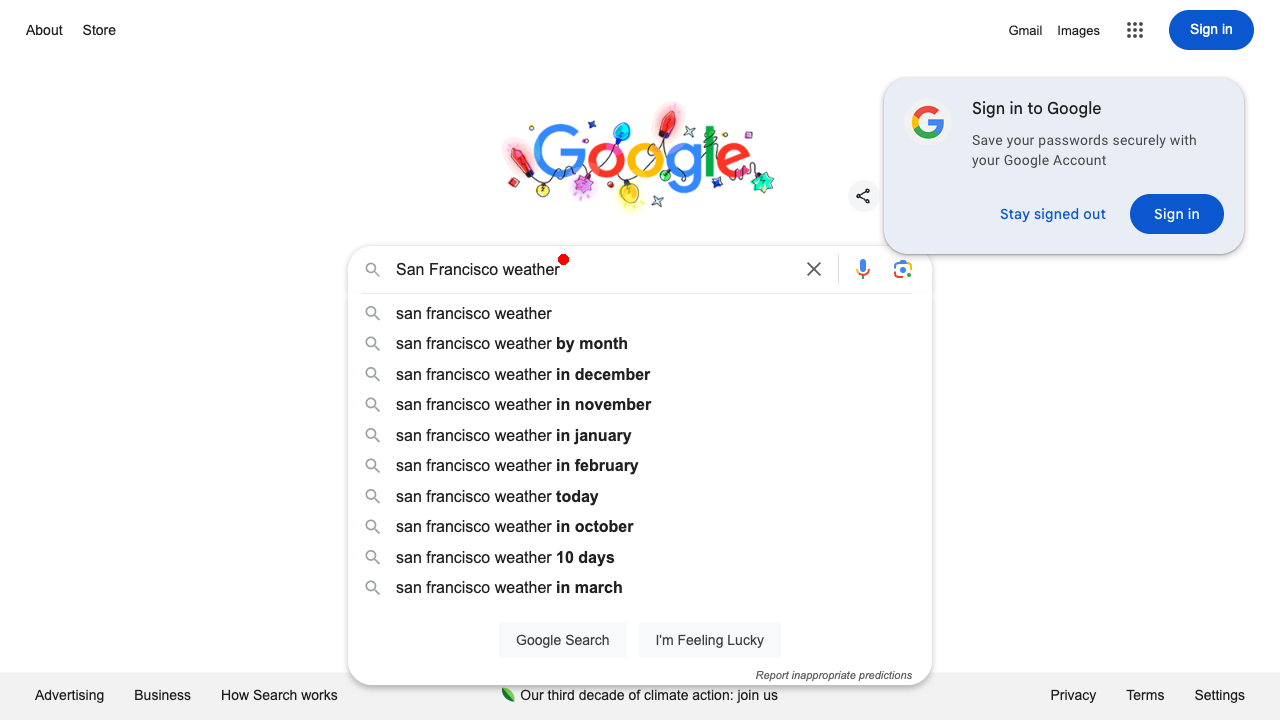

**Thoughts:** The screenshot shows a Google search page with the query "San Francisco weather" entered but not yet executed. The past action indicates that a click was made, likely to focus on the search input. The next task is to extract weather information, but this cannot be done until the search results are displayed.

**Instruction:** [MODIFY] Click "Google Search" to execute the query and display search results.
{'evaluator': {'plan': {'thoughts': "- The goal is to find out the weather in San Francisco. - The current screenshot shows the Google homepage, which is suitable for conducting a search. - The search bar is visible and can be used to input the query. - We need to enter 'San Francisco weather' into the search bar and execute the search.", 'tasks': [' Click "Google Search" to execute the query and display search results.']}, 'img': 'iVBORw0KGgoAAAANSUhEUgAABQAAAALQCAIAAABAH0oBAAAAAXNSR0IArs4c6QAAIABJREFUeJzs3Xd4FFXbBvDnzMz23XRCIJTQS4QIBEGULkVFeSmKqKiIiAiv2FFsfOiLBQtWLPSmII

GraphRecursionError: Recursion limit of 10 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [44]:
# Let's test the whole thing now

SCREEN_WIDTH=1280
SCREEN_HEIGHT=720

# open a browser
browser = await async_playwright().start()
# We will set headless=False so we can watch the agent navigate the web.
browser = await browser.chromium.launch(headless=False, args=None)
page = await browser.new_page()
await page.set_viewport_size({"width": SCREEN_WIDTH, "height": SCREEN_HEIGHT})
_ = await page.goto("https://www.google.com/")

initial_state = {
    "page": page,
    "objective": "What is the weather in San Francisco?",
    "scratchpad": [],
    "nav_scratchpad": []
}

event_stream = graph.astream(
        initial_state,
        {
                "recursion_limit": 10
        }
)

async for event in event_stream:
        print(event)

# Building the class

In [45]:
from src.llms import SHOWUI_TEMPLATE
class WebAgentV2:
    def __init__(self, orchestrator_prompt, formatter_prompt, evaluator_prompt, mm_llm_model: str = "gpt-4o", llm_model: str = "llama-3.3-70b-versatile"):

        # TODO(dominic): A model factory should handle this part
        self.mm_llm = ChatOpenAI(model=mm_llm_model)
        self.llm = ChatGroq(model=llm_model)

        self.orchestrator_agent = orchestrator_prompt | self.mm_llm | StrOutputParser()
        self.formatter = RunnablePassthrough.assign(
            plan=formatter_prompt
            | llm
            | StrOutputParser()
            | parse_formatter_string
        )    
        self.showui = ChatShowUI()
        self.nav_agent = RunnablePassthrough.assign(
            next_actions=self.get_task
            | SHOWUI_TEMPLATE
            | self.showui
            | StrOutputParser()
            | parse_llm_output
        )
        self.evaluator_agent = evaluator_prompt | self.mm_llm | StrOutputParser()
        
        self.tools = {
            "CLICK": click,
            "INPUT": type_text,
            "SELECT": click,
            "HOVER": hover,
            "ANSWER": answer,
            "ENTER": enter,
            "SCROLL": scroll,
            "SELECT_TEXT": select_text,
            "COPY": copy,
            # These next three are not known to the agent to be options
            "WAIT": wait,
            "GO_BACK": go_back,
            "GOOGLE": to_google,
        }

        self.graph = self._create_graph()
        
    def get_task(self, state: AgentState) -> str:
        return {"query": state["plan"]["tasks"][0], "img": state["img"]}
    
    async def orchestrator_node(self, state: AgentState) -> Command[Literal["formatter", "__end__"]]:
        screenshot = await state["page"].screenshot()
        encoded_screenshot = encode_image(screenshot)
        prediction = await self.orchestrator_agent.ainvoke({**state, "img": encoded_screenshot}) # TODO: this is inelegant considering the udpate below...

        # Add logic to determine if we have the answer or need to proceed to formatter
        if "ANSWER" in prediction:
            # TODO(dominic): We probably need to add some logic here to extract answer etc. 
            return Command(
                goto="__end__"
            )

        return Command(
            update={
                "prediction": prediction,
                "img": encoded_screenshot
            },
            goto = "formatter"
        )
    
    async def execute_actions(self, state: AgentState):
        """Function which takes the actions generated by the NavAgent, routes to corresponding functions, and executes"""
        next_actions = state.get("next_actions")
        scratchpad_additions = []

        prev_url = state["page"].url
        exit_code = "SUCCESS"
        page = state["page"]
        try:
            for action in next_actions:
                value, position = action["value"], action["position"]
                # unnormalize position if it is not None
                if position:
                    position = [position[0] * SCREEN_WIDTH, position[1] * SCREEN_HEIGHT]
                observation = await self.tools[action["action"]](page, value, position)
                scratchpad_additions.append(observation)
                # TODO(Ben): screenshot comparator here connected to exit code: STATE_CHANGE_FAILURE
                if prev_url != state["page"].url:
                    exit_code = "URL_CHANGE"
                    break
                if action["action"].lower() == "answer":
                    exit_code = "ANSWER"
                    break
        except Exception as e:
            print(f"Exception: {str(e)}")
            # introduce logic to figure out the exit code
            exit_code = "TOTAL_FAILURE"  # TODO: not all exceptions should necesarily be treated as total_failure, scope this out
            raise

        state["nav_scratchpad"] = scratchpad_additions

        return {**state, "exit_code": exit_code}
    
    async def evaluator_node(self, state: AgentState) -> Command[Literal["orchestrator", "navigator"]]:
        exit_code = state['exit_code']
        last_task = state['plan']['tasks'].pop(0)
        txt = state['scratchpad'][0].content if state['scratchpad'] else ""
        task_line = f"\n - Exit code: {exit_code}, Task: {last_task}"
        if exit_code == "TOTAL_FAILURE" or exit_code == "URL_CHANGE" or (exit_code == "SUCCESS" and not state['plan']['tasks']):
            txt += task_line
            return Command(
                update = {
                    "scratchpad": [HumanMessage(content=txt)],
                    "nav_scratchpad": []
                },
                goto = "orchestrator"
            )
        elif exit_code == "STATE_CHANGE_FAILURE":
            raise NotImplementedError("Currently STATE_CHANGE_FAILURE shouldn't occur, we need to figure out what to do.")
        elif exit_code == "SUCCESS" and state['plan']['tasks']:
            updated_screenshot = await state['page'].screenshot()
            updated_encoded_image = encode_image(updated_screenshot)
            last_action = None
            if state['next_actions']:
                # grab the last action
                idx = len(state['nav_scratchpad'])
                last_action = state['next_actions'][idx-1]
            
            if last_action:
                updated_screenshot = draw_point(updated_screenshot, last_action['position'])
            evaluation = await evaluator_agent.ainvoke({
                "previous_tasks": txt,
                "past_actions": state['nav_scratchpad'],
                "next_tasks": "\n - ".join(state['plan']['tasks']),
                "objective": state['objective'],
                "img": encode_image(updated_screenshot)
            })
            # parse evaluation
            thoughts, args = re.split(r"\[(?:CONTINUE|REPLAN|MODIFY|ANSWER)\]", evaluation, maxsplit=1) #TODO(dominic): not yet optimized parsing
            case = re.search(r"\[(?:CONTINUE|REPLAN|MODIFY|ANSWER)\]", evaluation)
            if case is not None:
                case = case.group(0)
            else:
                raise Exception

            if case == "[MODIFY]":
                new_plan = state['plan']
                new_plan['tasks'][0] = args # the evaluator has determined the next task needs changing
                return Command(
                    update={
                        "plan": new_plan, 
                        "img": updated_encoded_image
                    },
                    goto="navigator"
                )
            elif case == "[CONTINUE]":
                return Command(
                    update={
                        "img": updated_encoded_image
                    },
                    goto="navigator"
                )
            elif case == "[REPLAN]":
                txt += f"\n - Attempted task: {last_task}"
                txt += f"\n - Need to replan because: {args}"
                return Command(
                    update={
                        "scratchpad": [HumanMessage(content=txt)],
                        "nav_scratchpad": [], 
                        "img": updated_encoded_image
                    },
                    goto = "orchestrator"
                )
            elif case == "[ANSWER]":
                txt += task_line
                txt += f"\n - [ANSWER]: {args}"
                return Command(
                    update={
                        "scratchpad": [HumanMessage(content=txt)], 
                        "img": updated_encoded_image, 
                        "nav_scratchpad": []
                    },
                    goto="orchestrator"
                )
            else: NotImplementedError("Evaluator has returned unexpected flag...")

    def _create_graph(self):
        graph_builder = StateGraph(AgentState)

        # Add in the nodes
        graph_builder.add_node("orchestrator", self.orchestrator_node)
        graph_builder.add_edge(START, "orchestrator")


        graph_builder.add_node("formatter", self.formatter)
        # graph_builder.add_edge("orchestrator", "formatter")

        # add in nav agent
        graph_builder.add_node("navigator", self.nav_agent)
        graph_builder.add_edge("formatter", "navigator")

        # add in executor
        graph_builder.add_node("executor", self.execute_actions)
        graph_builder.add_edge("navigator", "executor")

        graph_builder.add_node("evaluator", self.evaluator_node)
        graph_builder.add_edge("executor", "evaluator")

        graph = graph_builder.compile()
        return graph
    
    async def run(
        self,
        start_url: str,
        objective: str,
        max_steps: int = 10,
        headless: bool = False,
    ):
        # open a browser
        browser = await async_playwright().start()
        # We will set headless=False so we can watch the agent navigate the web.
        browser = await browser.chromium.launch(headless=False, args=None)
        page = await browser.new_page()
        await page.set_viewport_size({"width": SCREEN_WIDTH, "height": SCREEN_HEIGHT})
        _ = await page.goto("https://www.google.com/")

        initial_state = {
            "page": page,
            "objective": "What is the weather in San Francisco?",
            "scratchpad": [],
            "nav_scratchpad": []
        }

        event_stream = graph.astream(
                initial_state,
                {
                        "recursion_limit": 10
                }
        )

        async for event in event_stream:
                print(event)

        # TODO(dominic): need to figure out exactly what we want to return
        return
    
    